In [2]:
!pip install tabpfn

In [3]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_csv('data/unique_outages2.csv', parse_dates=['Start', 'Finish', 'file_name'])

# # removed unplanned
# df = df[df['Unplanned?'] != 1]
# # filter the duration hours, only if there are expected outages, and non-outlier values, remove the one 'VIC/ TAS'
# df = df[(df['Duration_Hours'] <= 1000) &(df['Duration_Hours'] != 0) & (df['Region'] != 'VIC/ TAS')]

# df['Duration_Category'] = pd.qcut(df['Duration_Hours'], q=6, duplicates='drop')
# df['Duration_Category'] = df['Duration_Category'].astype(str)

In [6]:
# # Get the boxplot summary statistics
# summary_stats = {
#     'Lower Whisker': 2.75,
#     'Q1': 9.5,
#     'Median': 11.0,
#     'Q3': 14.0,
#     'Upper Whisker': 20.75
# }

# # Define the bins and labels based on the summary statistics
# bins = [
#     -float('inf'),  # For values below the lower whisker (outliers)
#     summary_stats["Lower Whisker"], 
#     summary_stats["Q1"],
#     summary_stats["Median"],
#     summary_stats["Q3"],
#     summary_stats["Upper Whisker"],
#     float('inf')    # For values above the upper whisker (outliers)
# ]

# labels = [
#     f'0–{summary_stats["Lower Whisker"]:.1f} hrs',      # Outliers: Below lower whisker
#     f'{summary_stats["Lower Whisker"]:.1f}–{summary_stats["Q1"]:.1f} hrs', # lower whisker to Q1
#     f'{summary_stats["Q1"]:.1f}–{summary_stats["Median"]:.1f} hrs',       # Q1 to median
#     f'{summary_stats["Median"]:.1f}–{summary_stats["Q3"]:.1f} hrs',       # median to Q3
#     f'{summary_stats["Q3"]:.1f}–{summary_stats["Upper Whisker"]:.1f} hrs', # Q3 to upper whisker
#     f'{summary_stats["Upper Whisker"]:.1f}+ hrs'         # Outliers: Above upper whisker
# ]

# # Add a new column to the original dataframe with the appropriate bin labels
# df['Duration_Category'] = pd.cut(df['Duration_Hours'], bins=bins, labels=labels, right=False)

# Display the first few rows to confirm the new column
# print(df[['Duration_Hours', 'Duration_Category']].head())
print(df['Duration_Category'].value_counts())

Duration_Category
11.0–14.0 hrs    649
20.8+ hrs        558
9.5–11.0 hrs     525
2.8–9.5 hrs      395
0–2.8 hrs        114
14.0–20.8 hrs     30
Name: count, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score

# Define features and target
features = ['Recall_Day_Hours', 'Recall_Night_Hours', # numerical cols
            'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional', # boolean cols
            'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description'] # categorical cols
target = 'Duration_Category'

# Drop rows with missing values in relevant columns
df = df.dropna(subset=features + [target])

# Encode categorical features
X = df[features].copy()
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Encode the target
y = LabelEncoder().fit_transform(df[target])

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

/opt/conda/lib/python3.11/site-packages/tabpfn/base.py:89: UserWarning: Downloading model to /tmp/.cache/tabpfn/tabpfn-v2-classifier.ckpt.
  model, _, config_ = load_model_criterion_config(


tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]


Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.66      0.47      0.55        58
           1       0.64      0.71      0.67       316
           2       0.60      0.18      0.27        17
           3       0.80      0.55      0.65       195
           4       0.84      0.82      0.83       279
           5       0.56      0.68      0.61       268

    accuracy                           0.68      1133
   macro avg       0.68      0.57      0.60      1133
weighted avg       0.70      0.68      0.68      1133



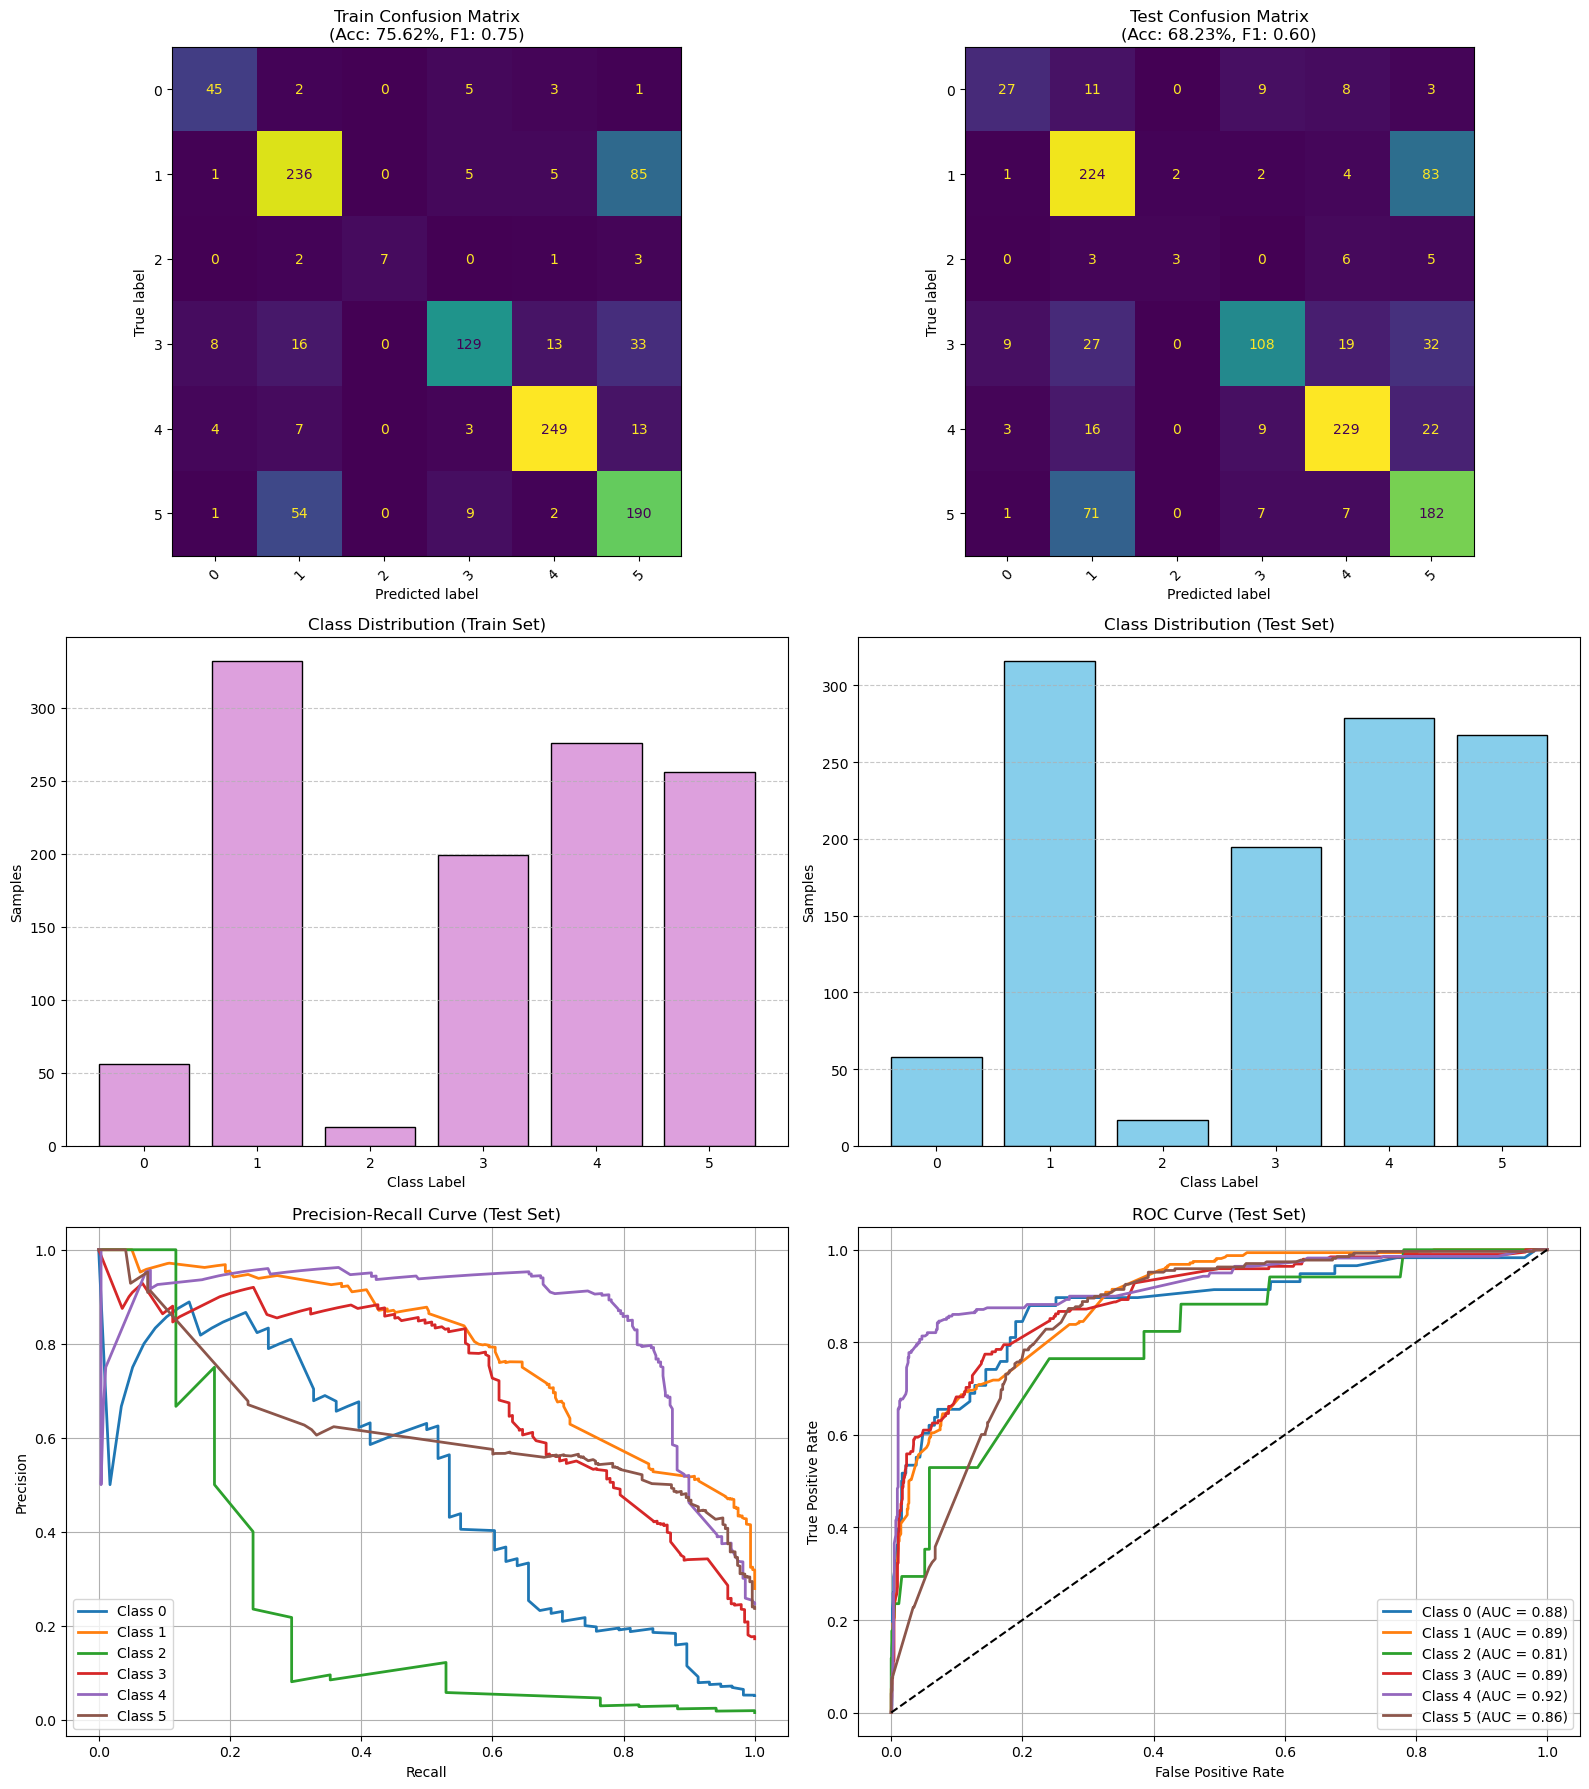

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tabpfn import TabPFNClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    precision_recall_curve, roc_curve, auc, accuracy_score, f1_score
)
from sklearn.preprocessing import label_binarize

# --- Train the classifier ---
clf = TabPFNClassifier(device="cuda")  # or "cpu" if needed
clf.fit(X_train, y_train)

# --- Predictions and probabilities ---
train_preds = clf.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)
train_f1 = f1_score(y_train, train_preds, average="macro")

test_preds = clf.predict(X_test)
test_acc = accuracy_score(y_test, test_preds)
test_f1 = f1_score(y_test, test_preds, average="macro")

y_score = clf.predict_proba(X_test)

# --- Print classification report ---
print("\nClassification Report (Test Set):\n")
print(classification_report(y_test, test_preds))

# --- Prepare binarized labels for PR and ROC ---
y_test_bin = label_binarize(y_test, classes=clf.classes_)
n_classes = y_test_bin.shape[1]

# --- Set up 3x2 grid ---
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# --- Row 1: Confusion Matrices ---
# Train
train_cm = confusion_matrix(y_train, train_preds)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm)
disp_train.plot(cmap='viridis', ax=axes[0, 0], xticks_rotation=45, colorbar=False)
axes[0, 0].set_title(f"Train Confusion Matrix\n(Acc: {train_acc:.2%}, F1: {train_f1:.2f})")

# Test
test_cm = confusion_matrix(y_test, test_preds)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm)
disp_test.plot(cmap='viridis', ax=axes[0, 1], xticks_rotation=45, colorbar=False)
axes[0, 1].set_title(f"Test Confusion Matrix\n(Acc: {test_acc:.2%}, F1: {test_f1:.2f})")

# --- Row 2: Class Distributions ---
# Train
train_counts = pd.Series(y_train).value_counts().sort_index()
axes[1, 0].bar(train_counts.index.astype(str), train_counts.values, color='plum', edgecolor='black')
axes[1, 0].set_xlabel('Class Label')
axes[1, 0].set_ylabel('Samples')
axes[1, 0].set_title('Class Distribution (Train Set)')
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Test
test_counts = pd.Series(y_test).value_counts().sort_index()
axes[1, 1].bar(test_counts.index.astype(str), test_counts.values, color='skyblue', edgecolor='black')
axes[1, 1].set_xlabel('Class Label')
axes[1, 1].set_ylabel('Samples')
axes[1, 1].set_title('Class Distribution (Test Set)')
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

# --- Row 3: PR and ROC Curves ---
# Precision-Recall
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    axes[2, 0].plot(recall, precision, lw=2, label=f'Class {clf.classes_[i]}')
axes[2, 0].set_xlabel('Recall')
axes[2, 0].set_ylabel('Precision')
axes[2, 0].set_title('Precision-Recall Curve (Test Set)')
axes[2, 0].legend(loc='lower left')
axes[2, 0].grid()

# ROC Curve
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    axes[2, 1].plot(fpr, tpr, lw=2, label=f'Class {clf.classes_[i]} (AUC = {roc_auc:.2f})')
axes[2, 1].plot([0, 1], [0, 1], 'k--', lw=1.5)
axes[2, 1].set_xlabel('False Positive Rate')
axes[2, 1].set_ylabel('True Positive Rate')
axes[2, 1].set_title('ROC Curve (Test Set)')
axes[2, 1].legend(loc='lower right')
axes[2, 1].grid()

# --- Final layout ---
plt.tight_layout()
plt.show()

In [9]:
from tabpfn import TabPFNClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    precision_recall_curve, roc_curve, auc, accuracy_score, f1_score
)
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def train_and_evaluate_tabpfn(region_df, feature_cols, target_col):
    """
    Train TabPFNClassifier and plot evaluation metrics for a given region DataFrame.

    Parameters:
        region_df (pd.DataFrame): Region-specific data.
        feature_cols (list): List of feature column names.
        target_col (str): Name of the target column.

    Returns:
        clf (TabPFNClassifier): Trained model.
    """
    # Define your full label order
    full_label_order = [
        '0–2.8 hrs',
        '2.8–9.5 hrs',
        '9.5–11.0 hrs',
        '11.0–14.0 hrs',
        '14.0–20.8 hrs',
        '20.8+ hrs'
    ]
    label_indices = list(range(len(full_label_order)))

    # Drop missing values
    region_df = region_df.dropna(subset=feature_cols + [target_col])

    # Encode features
    X = region_df[feature_cols].copy()
    for col in X.select_dtypes(include='object').columns:
        X[col] = LabelEncoder().fit_transform(X[col])

    # Encode target with known class order
    le = LabelEncoder()
    le.fit(full_label_order)
    y = le.transform(region_df[target_col])

    # Remove rare classes (< 2 samples)
    class_counts = pd.Series(y).value_counts()
    valid_classes = class_counts[class_counts >= 2].index
    mask = np.isin(y, valid_classes)
    X = X[mask]
    y = y[mask]

    # Train/test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    # Train TabPFN
    clf = TabPFNClassifier(device='cuda')
    clf.fit(X_train, y_train)

    # Predict and get probabilities
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)

    # Compute metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="macro", zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average="macro", zero_division=0)

    # Print classification report
    print("\nClassification Report (Test Set):")
    print(classification_report(
        y_test, y_test_pred,
        labels=label_indices,
        target_names=full_label_order,
        zero_division=0
    ))

    # --- Create 3x2 subplot layout ---
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))

    # Row 1: Confusion matrices
    cm_train = confusion_matrix(y_train, y_train_pred, labels=label_indices)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=full_label_order)
    disp_train.plot(cmap='viridis', ax=axes[0, 0], xticks_rotation=45, colorbar=False)
    axes[0, 0].set_title(f"Train Confusion Matrix\n(Acc: {train_acc:.2%}, F1: {train_f1:.2f})")

    cm_test = confusion_matrix(y_test, y_test_pred, labels=label_indices)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=full_label_order)
    disp_test.plot(cmap='viridis', ax=axes[0, 1], xticks_rotation=45, colorbar=False)
    axes[0, 1].set_title(f"Test Confusion Matrix\n(Acc: {test_acc:.2%}, F1: {test_f1:.2f})")

    # Row 2: Class distributions
    train_counts = pd.Series(y_train).value_counts().reindex(label_indices, fill_value=0)
    test_counts = pd.Series(y_test).value_counts().reindex(label_indices, fill_value=0)

    axes[1, 0].bar(full_label_order, train_counts.values, color='plum', edgecolor='black')
    axes[1, 0].set_title("Train Class Distribution")
    axes[1, 0].set_xlabel("Class")
    axes[1, 0].set_ylabel("Count")
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

    axes[1, 1].bar(full_label_order, test_counts.values, color='skyblue', edgecolor='black')
    axes[1, 1].set_title("Test Class Distribution")
    axes[1, 1].set_xlabel("Class")
    axes[1, 1].set_ylabel("Count")
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

    # Row 3: PR and ROC curves
    y_test_bin = label_binarize(y_test, classes=label_indices)

    # Precision-Recall Curve
    for i in label_indices:
        if i >= y_score.shape[1]:  # skip missing columns
            continue
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        axes[2, 0].plot(recall, precision, lw=2, label=full_label_order[i])
    axes[2, 0].set_title("Precision-Recall Curve (Test Set)")
    axes[2, 0].set_xlabel("Recall")
    axes[2, 0].set_ylabel("Precision")
    axes[2, 0].legend(loc='lower left')
    axes[2, 0].grid()
    
    # ROC Curve
    for i in label_indices:
        if i >= y_score.shape[1]:  # skip missing columns
            continue
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        axes[2, 1].plot(fpr, tpr, lw=2, label=f'{full_label_order[i]} (AUC = {roc_auc:.2f})')
    axes[2, 1].plot([0, 1], [0, 1], 'k--', lw=1.5)
    axes[2, 1].set_title("ROC Curve (Test Set)")
    axes[2, 1].set_xlabel("False Positive Rate")
    axes[2, 1].set_ylabel("True Positive Rate")
    axes[2, 1].legend(loc='lower right')
    axes[2, 1].grid()


    plt.tight_layout()
    plt.show()

    return clf



--- Region: SA ---

Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       1.00      0.80      0.89         5
  2.8–9.5 hrs       0.50      0.60      0.55         5
 9.5–11.0 hrs       0.00      0.00      0.00         2
11.0–14.0 hrs       0.80      0.73      0.76        11
14.0–20.8 hrs       0.95      0.98      0.97        59
    20.8+ hrs       0.33      0.50      0.40         2

     accuracy                           0.88        84
    macro avg       0.60      0.60      0.59        84
 weighted avg       0.87      0.88      0.87        84



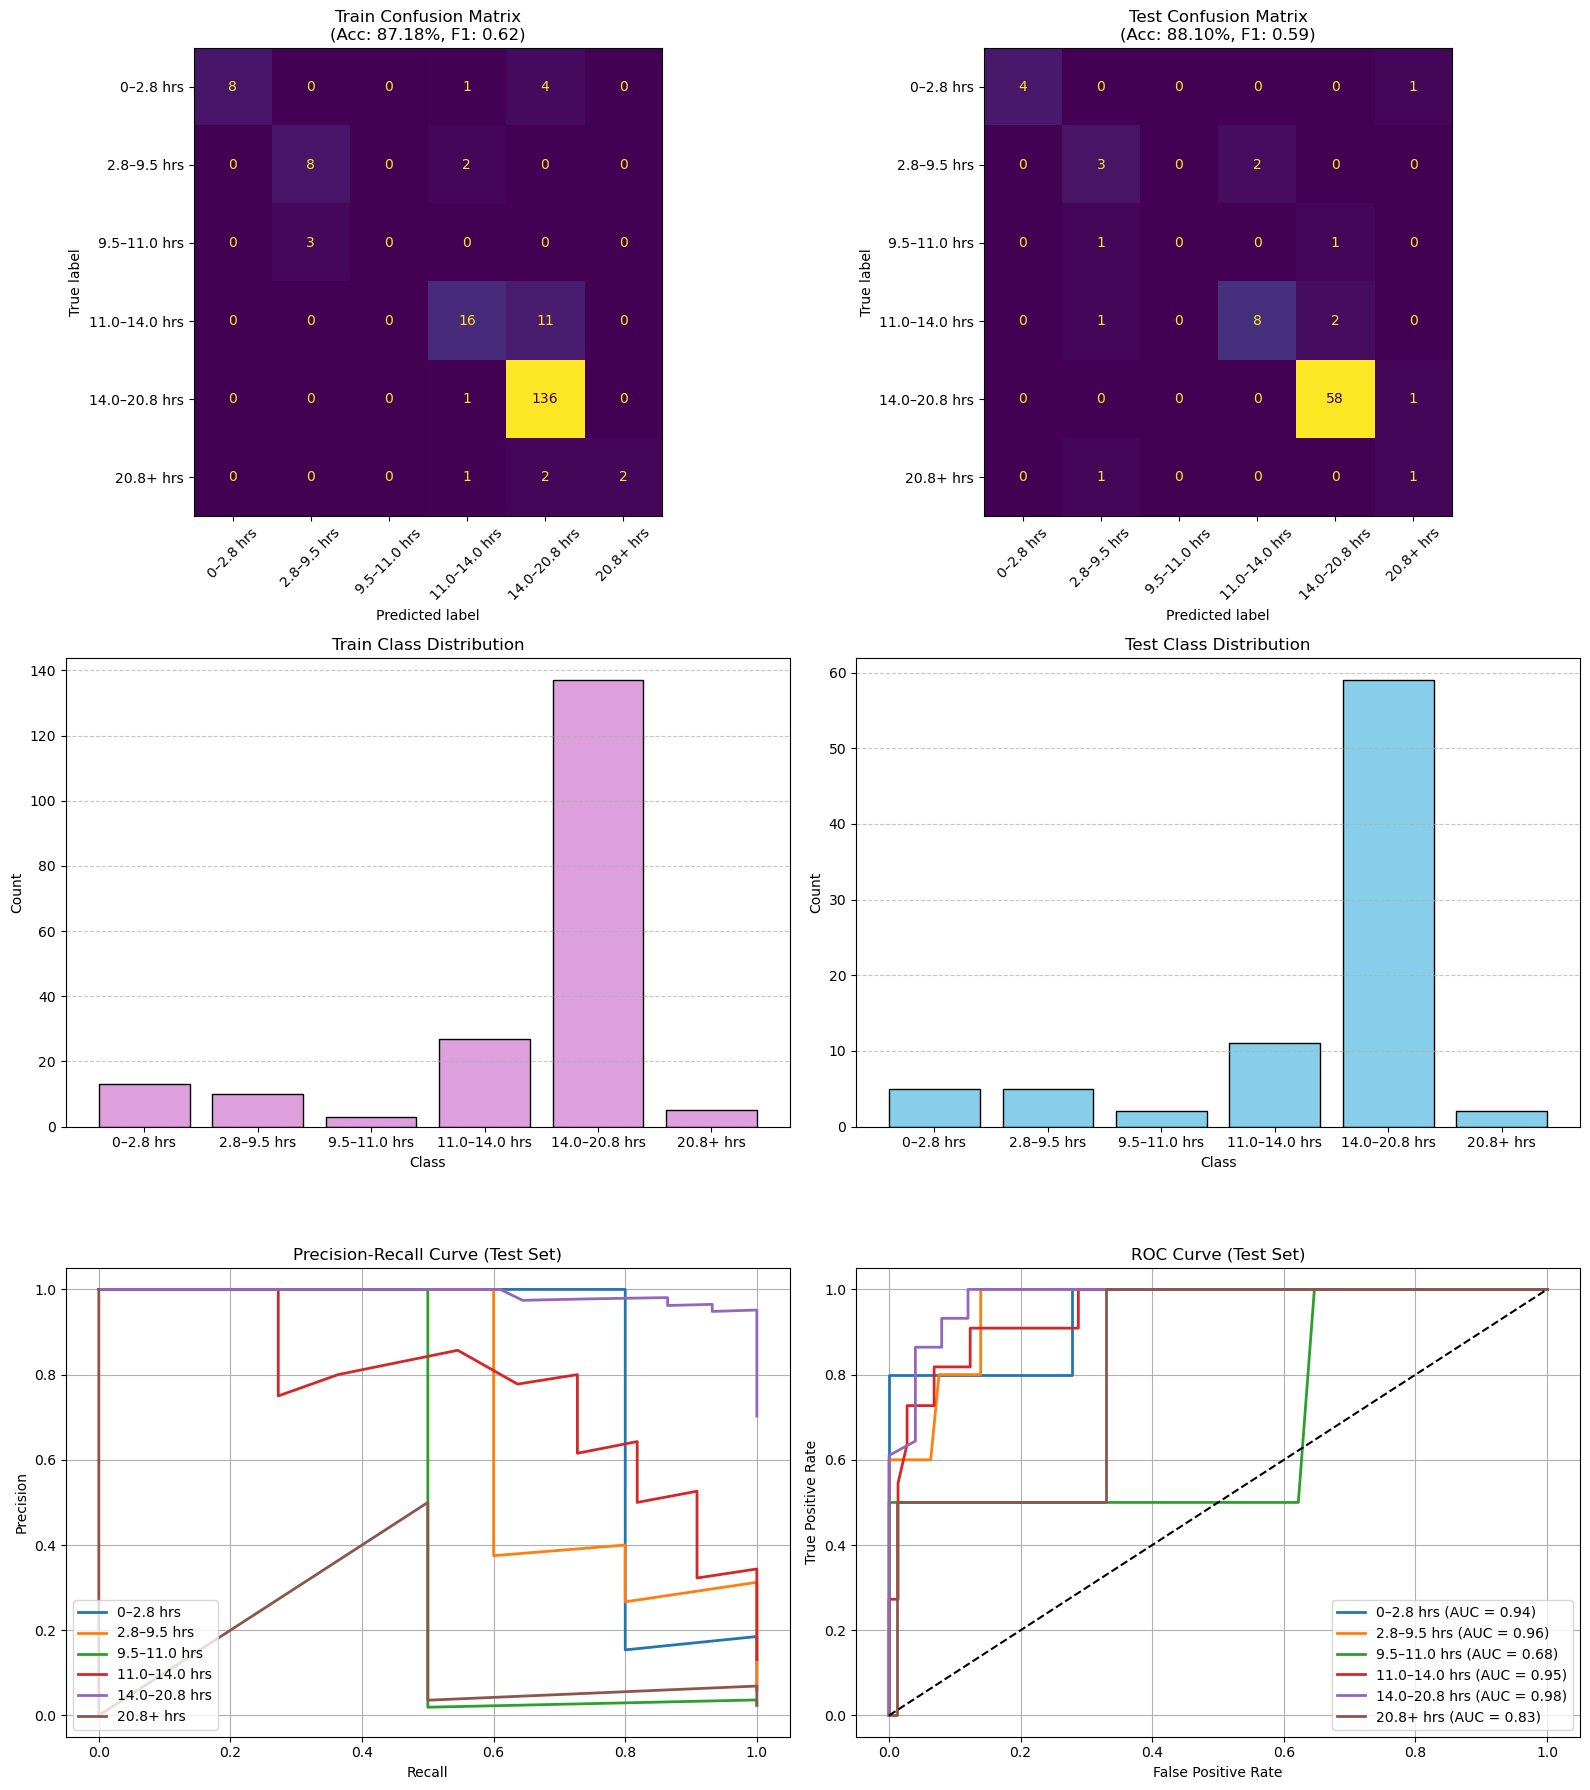


--- Region: VIC ---

Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.67      0.22      0.33         9
  2.8–9.5 hrs       0.70      0.63      0.66       167
 9.5–11.0 hrs       0.00      0.00      0.00         4
11.0–14.0 hrs       0.64      0.21      0.32        33
14.0–20.8 hrs       0.91      0.34      0.50        29
    20.8+ hrs       0.53      0.81      0.64       127

     accuracy                           0.62       369
    macro avg       0.57      0.37      0.41       369
 weighted avg       0.64      0.62      0.60       369



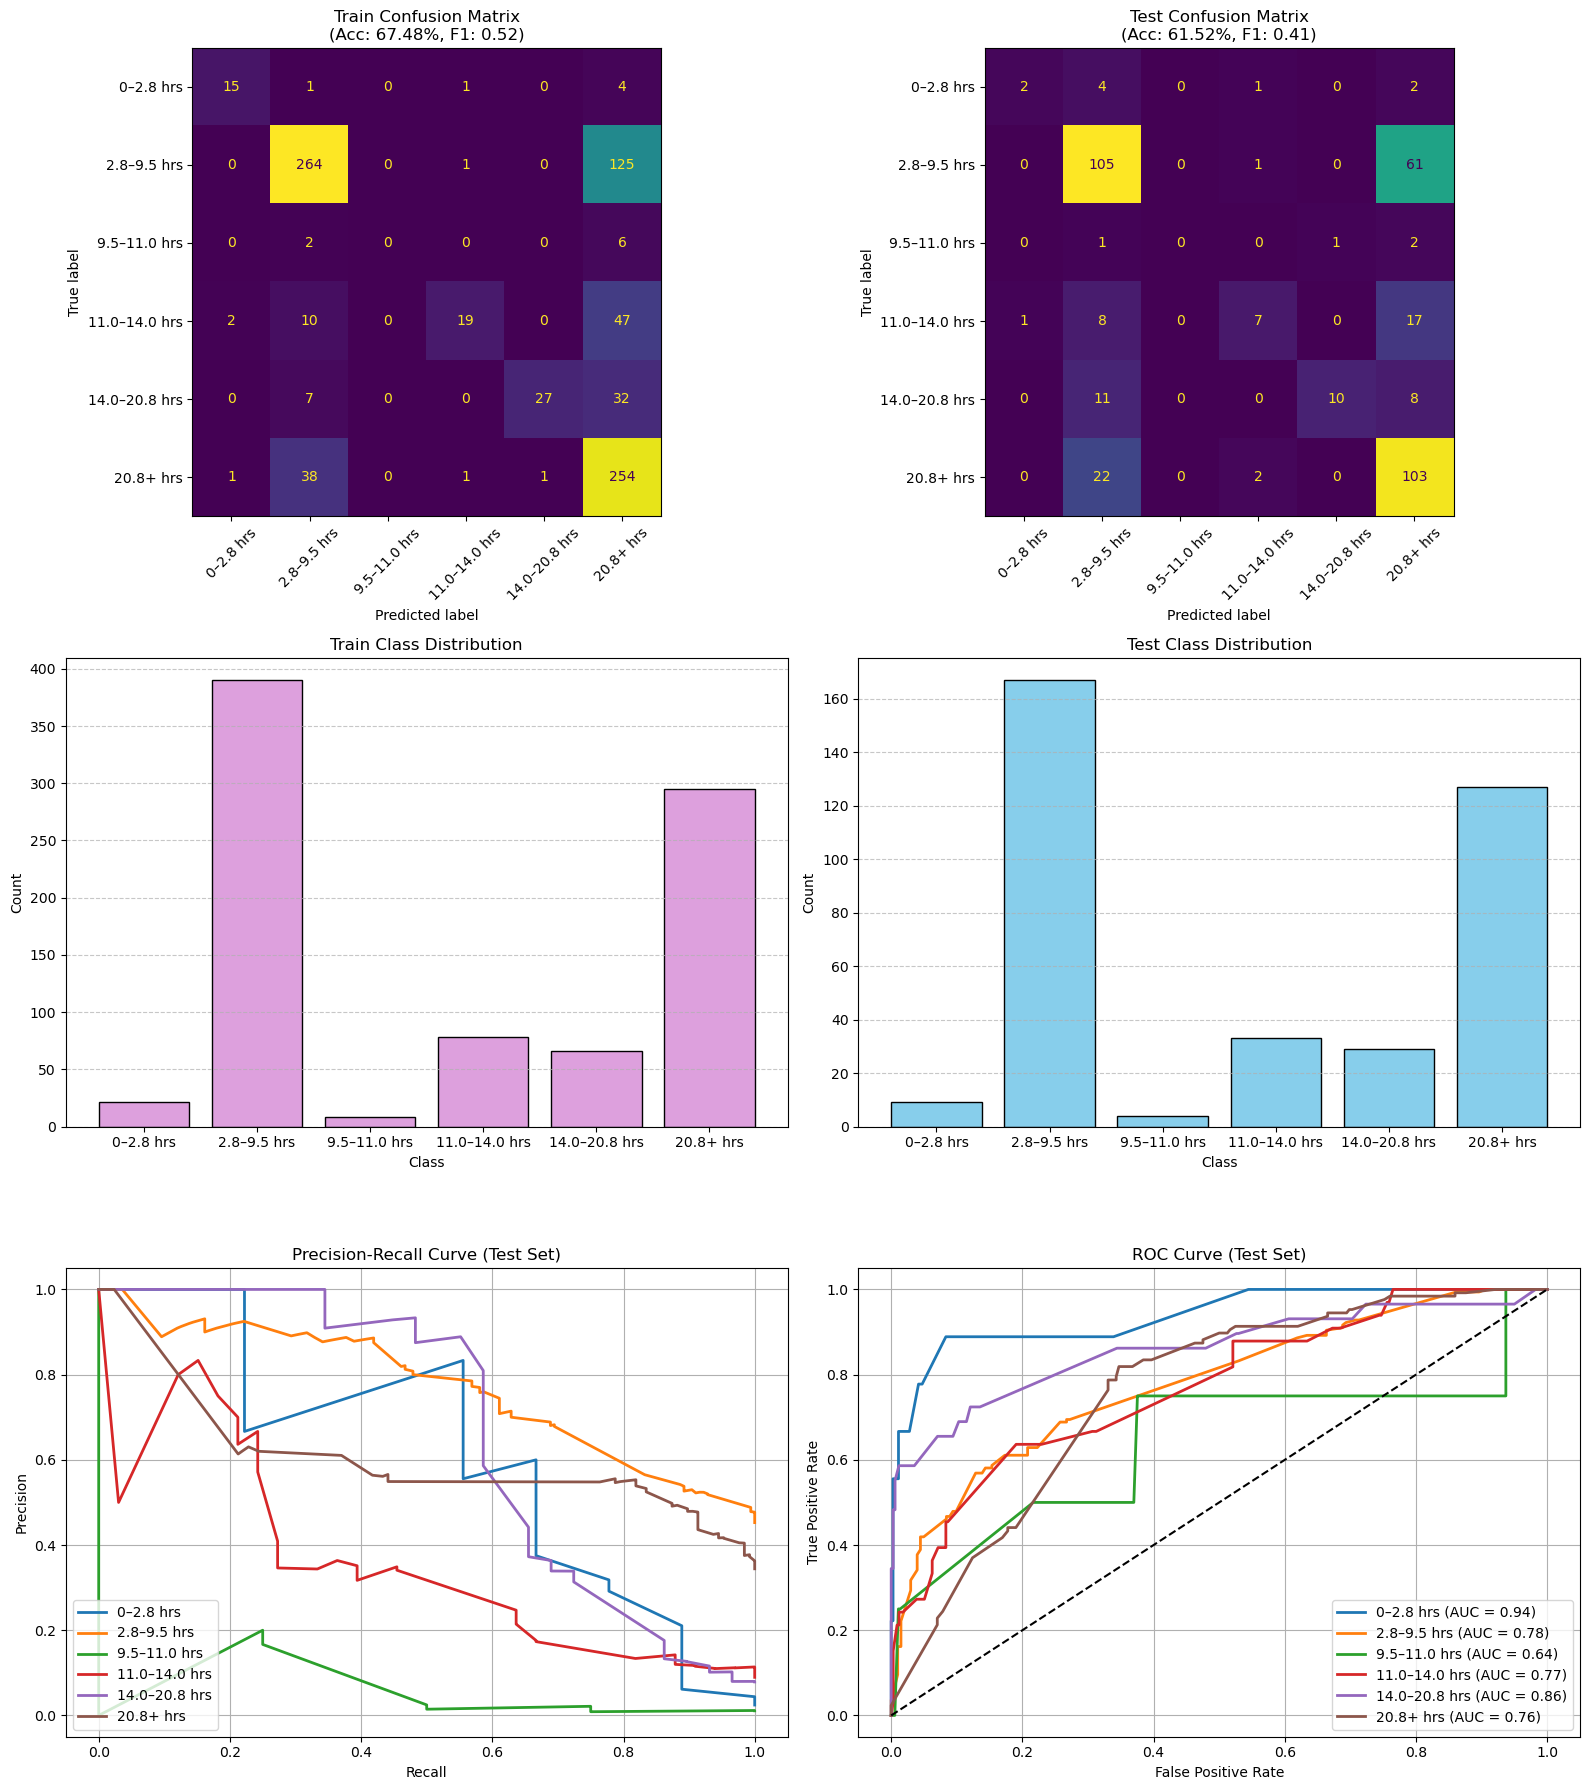


--- Region: TAS ---

Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.57      0.57      0.57         7
  2.8–9.5 hrs       0.00      0.00      0.00         0
 9.5–11.0 hrs       0.00      0.00      0.00         0
11.0–14.0 hrs       0.80      0.91      0.85        22
14.0–20.8 hrs       1.00      0.82      0.90        11
    20.8+ hrs       0.00      0.00      0.00         1

     accuracy                           0.80        41
    macro avg       0.40      0.38      0.39        41
 weighted avg       0.80      0.80      0.80        41



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


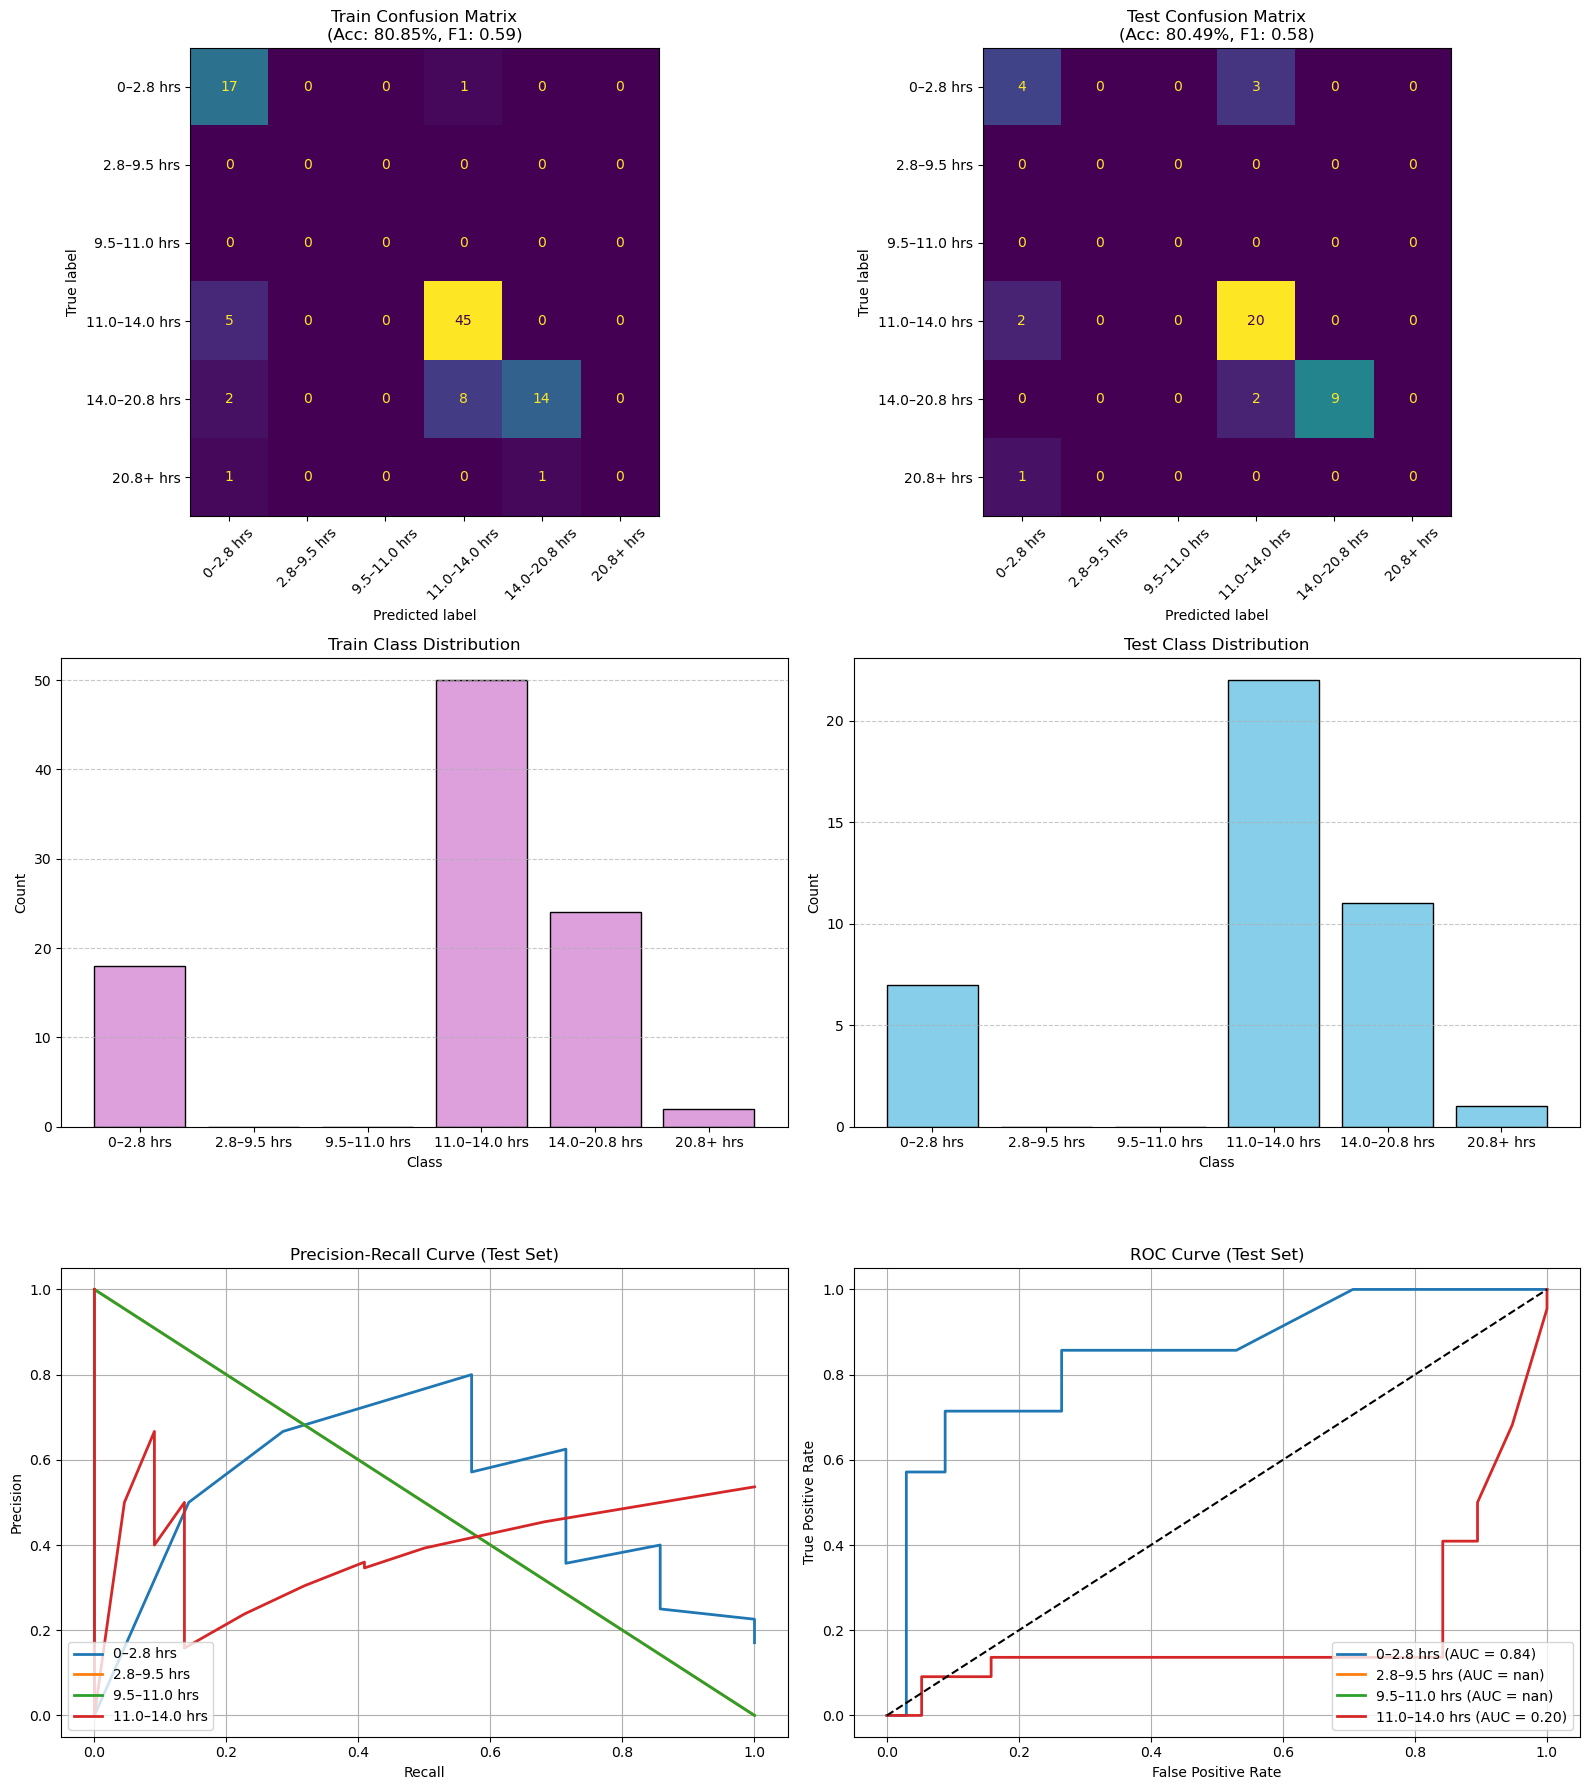


--- Region: QLD ---

Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.43      0.60      0.50        10
  2.8–9.5 hrs       0.00      0.00      0.00         1
 9.5–11.0 hrs       0.00      0.00      0.00         0
11.0–14.0 hrs       0.77      0.76      0.76        45
14.0–20.8 hrs       0.84      0.93      0.88        44
    20.8+ hrs       0.00      0.00      0.00         7

     accuracy                           0.76       107
    macro avg       0.34      0.38      0.36       107
 weighted avg       0.71      0.76      0.73       107



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


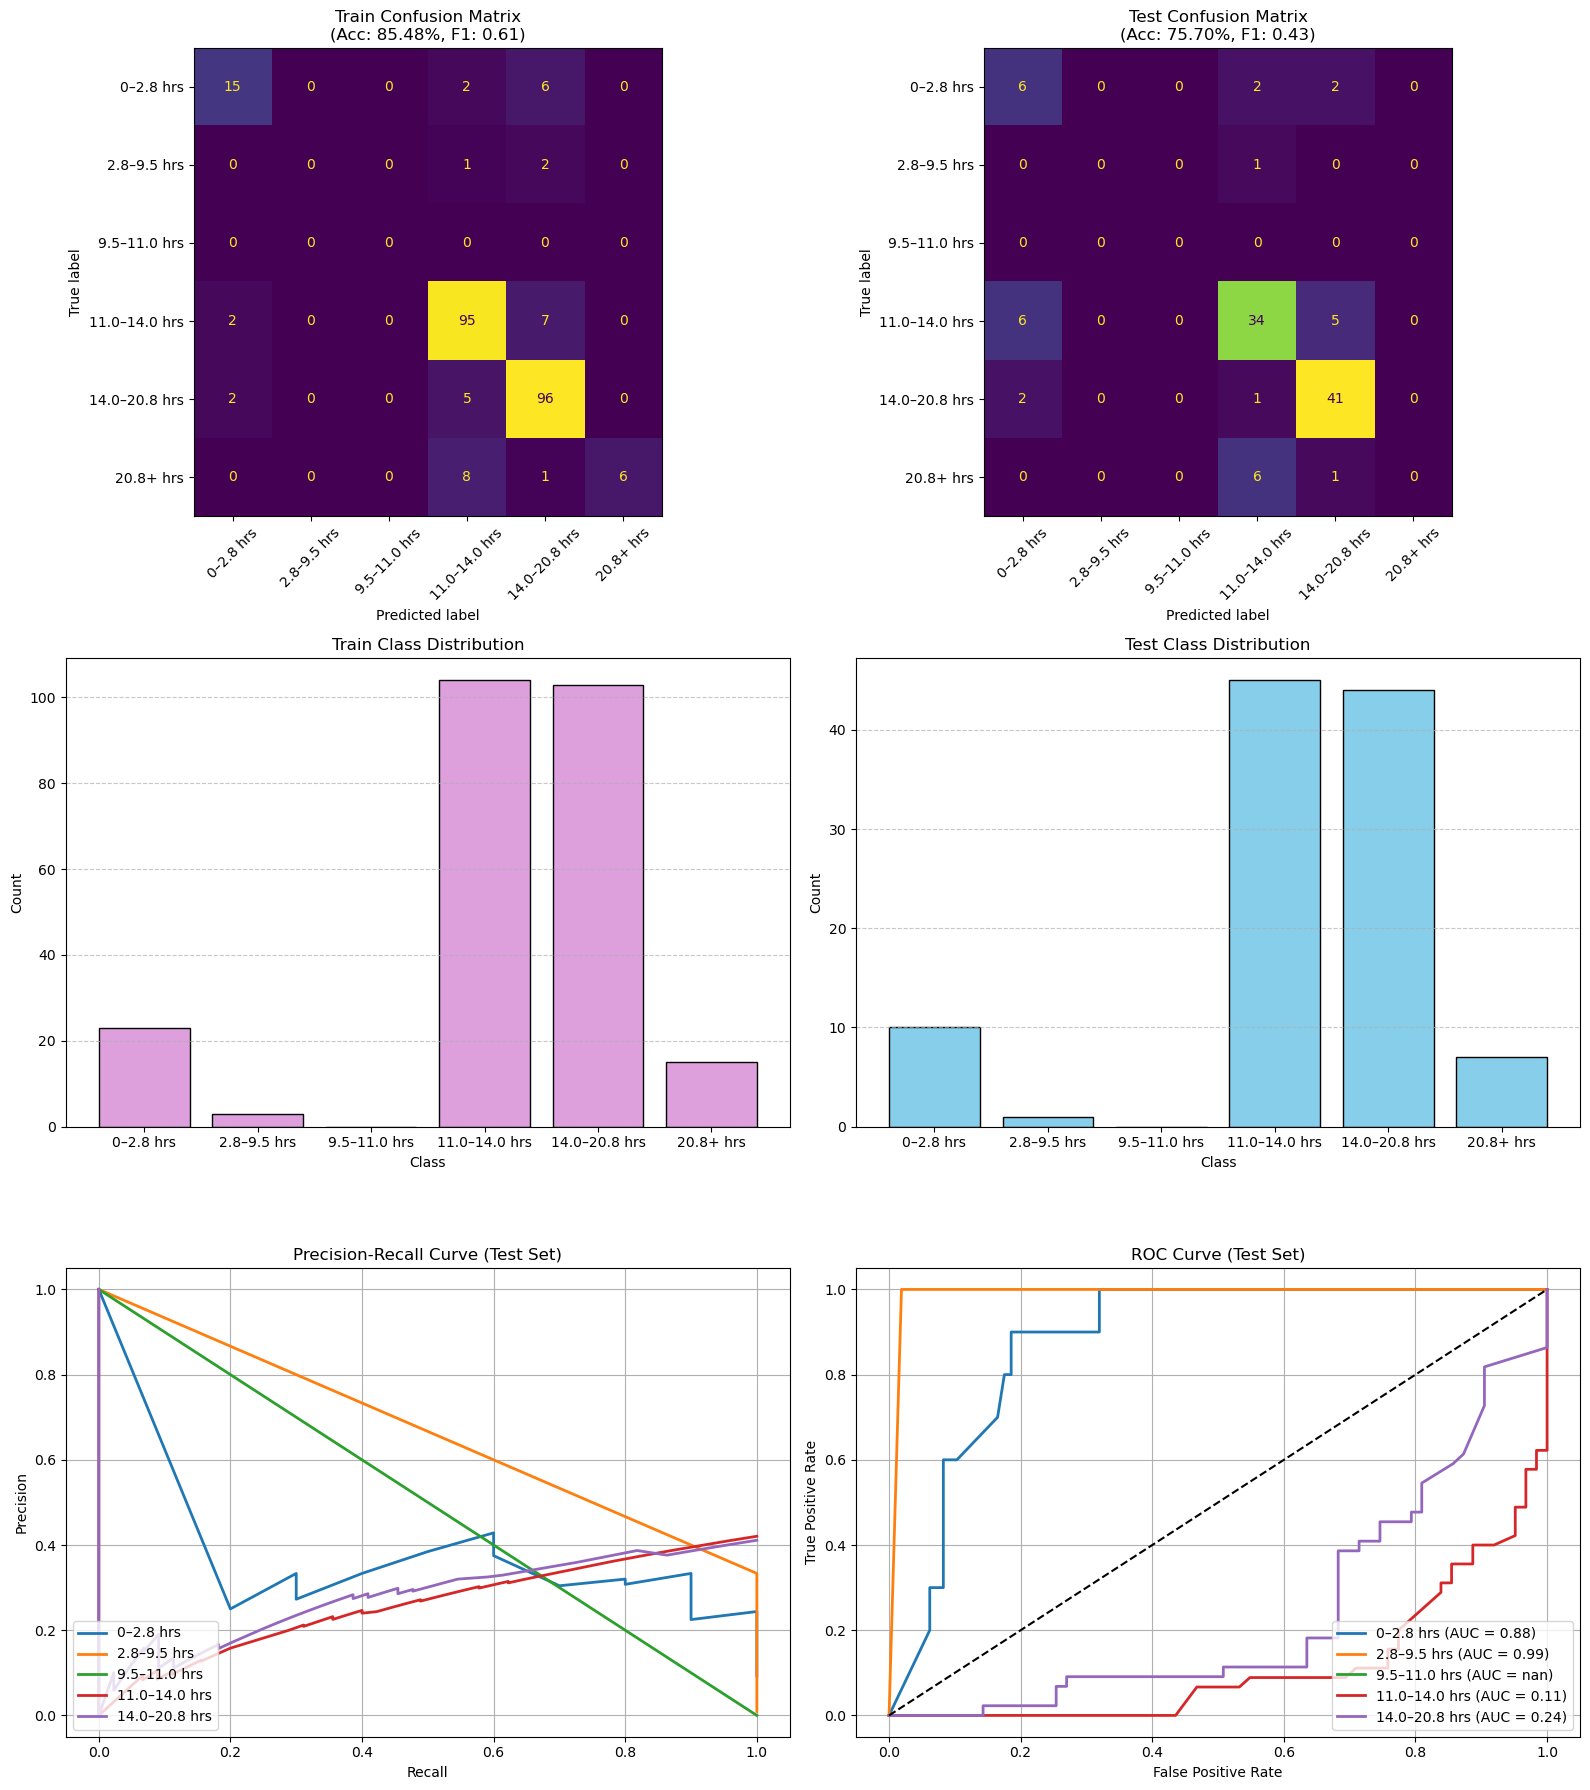


--- Region: NSW ---

Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.00      0.00      0.00         2
  2.8–9.5 hrs       0.53      0.86      0.66        22
 9.5–11.0 hrs       1.00      0.25      0.40         4
11.0–14.0 hrs       0.40      0.29      0.33         7
14.0–20.8 hrs       0.89      0.96      0.92        25
    20.8+ hrs       0.75      0.43      0.55        21

     accuracy                           0.68        81
    macro avg       0.59      0.46      0.48        81
 weighted avg       0.70      0.68      0.65        81



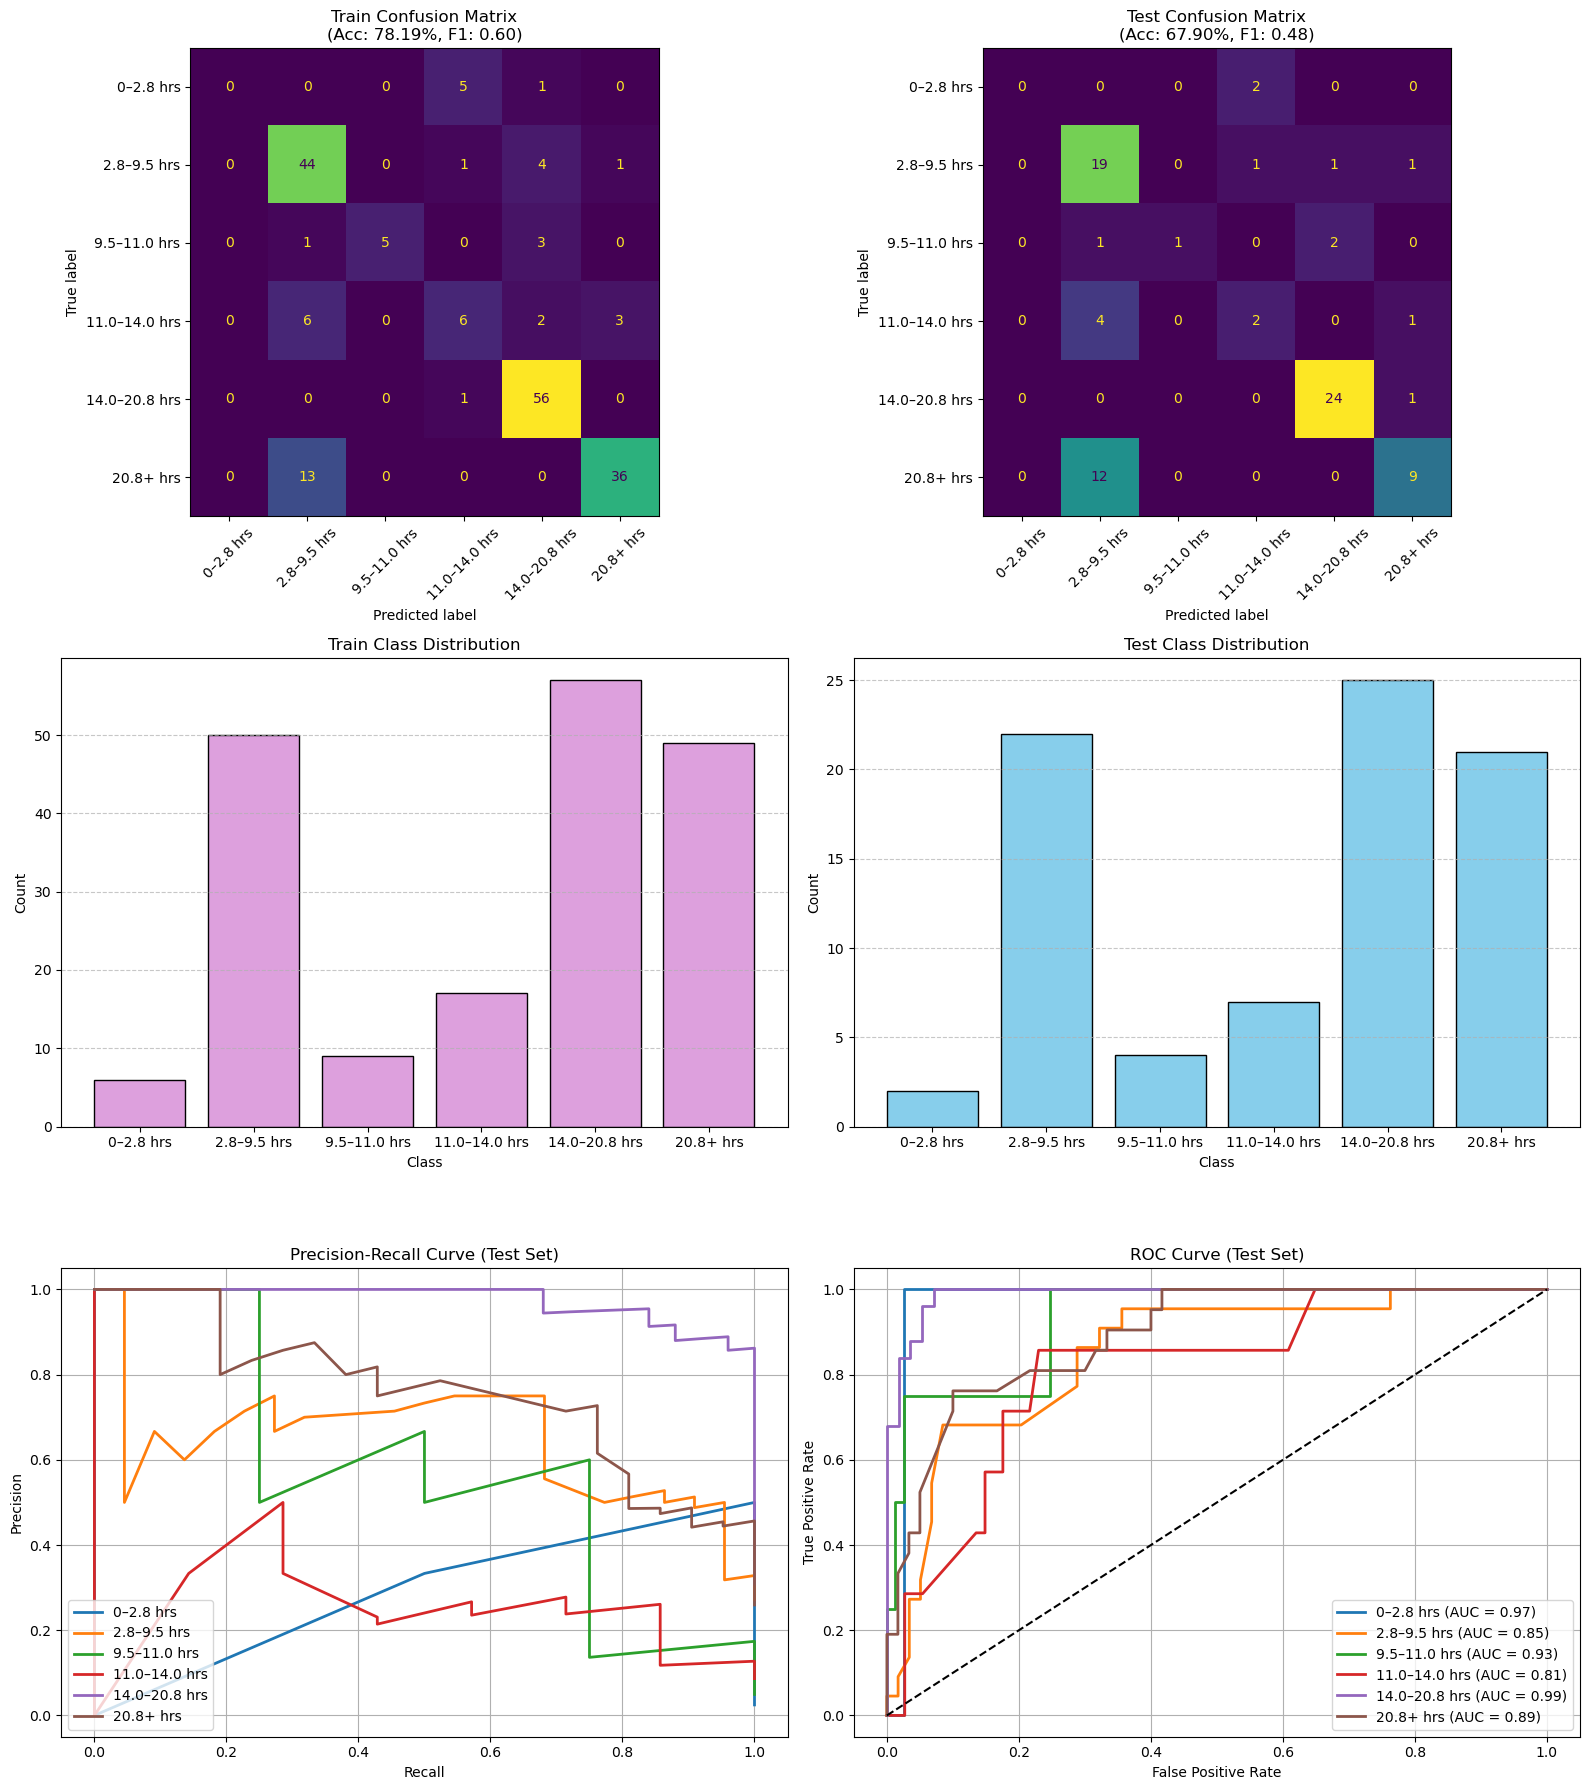

In [10]:
feature_cols = ['Recall_Day_Hours', 'Recall_Night_Hours', # numerical cols
            'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional', # boolean cols
            'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description'] # categorical cols

target_col = 'Duration_Category'



region_models = {}
for region in df['Region'].unique():
    print(f"\n--- Region: {region} ---")
    region_df = df[df['Region'] == region].copy()
    model = train_and_evaluate_tabpfn(region_df, feature_cols, target_col)
    region_models[region] = model